In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from Generator3D import *

In [14]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [15]:
train_dataset = TORCHDataset(100, 120, 92, 50, 300)
test_dataset = TORCHDataset(100, 120, 92, 50, 1)

In [16]:
type(train_dataset[0])

tuple

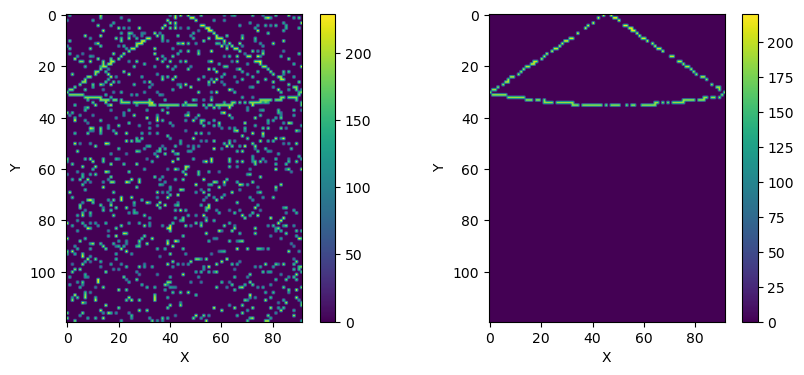

In [17]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plot2d(train_dataset[0][0])
ax2 = fig.add_subplot(122)
plot2d(train_dataset[0][1])

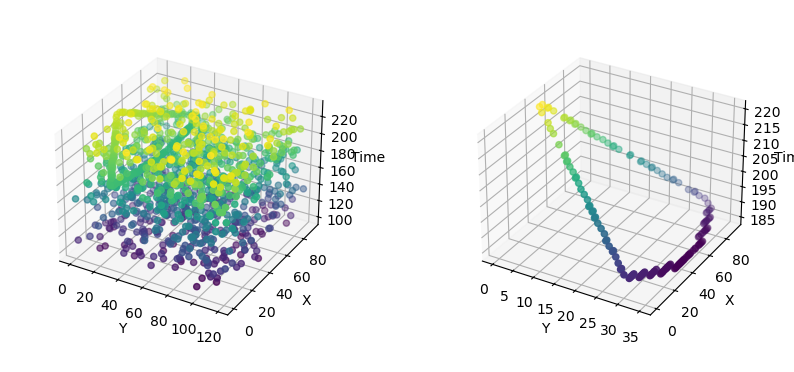

In [18]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
plot3d(train_dataset[0][0], ax1)
ax2 = fig.add_subplot(122, projection='3d')
plot3d(train_dataset[0][1], ax2)

In [19]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
summary(ConvolutionAutoencoder(), input_size=(300, 1, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [300, 1, 120, 92]         --
├─Sequential: 1-1                        [300, 8, 114, 86]         --
│    └─Conv2d: 2-1                       [300, 64, 118, 90]        640
│    └─BatchNorm2d: 2-2                  [300, 64, 118, 90]        128
│    └─ReLU: 2-3                         [300, 64, 118, 90]        --
│    └─Conv2d: 2-4                       [300, 16, 116, 88]        9,232
│    └─BatchNorm2d: 2-5                  [300, 16, 116, 88]        32
│    └─ReLU: 2-6                         [300, 16, 116, 88]        --
│    └─Conv2d: 2-7                       [300, 8, 114, 86]         1,160
│    └─BatchNorm2d: 2-8                  [300, 8, 114, 86]         16
│    └─ReLU: 2-9                         [300, 8, 114, 86]         --
├─Sequential: 1-2                        [300, 1, 120, 92]         --
│    └─BatchNorm2d: 2-10                 [300, 8, 114, 86]         16
│    └─

In [21]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [22]:
noisy_data = train_dataset.x.unsqueeze(1)
data = train_dataset.y.unsqueeze(1)

In [23]:
for i in tqdm(range(500)):
    optimiser.zero_grad()
    outputs = autoencoder(noisy_data.to(device))
    loss = loss_function(outputs, data.to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


In [24]:
test_data = test_dataset.x.unsqueeze(1)

In [25]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data.to("cpu"))
    pred = pred.squeeze()

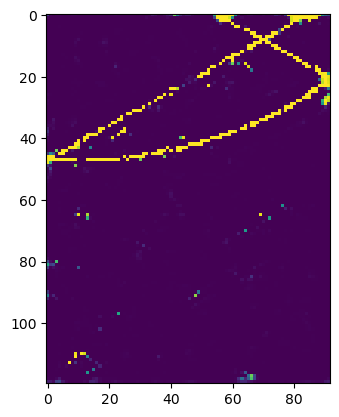

In [27]:
plt.imshow(pred)

TypeError: Invalid shape (92,) for image data

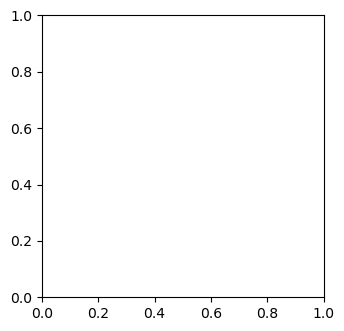

In [26]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
plot2d(pred[0])
ax2 = fig.add_subplot(122)
plot2d(pred[1])

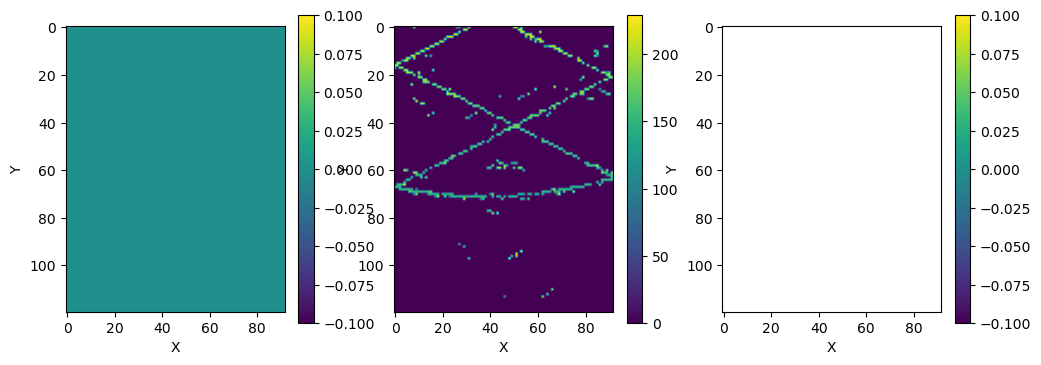

In [ ]:
a = (pred[0] > 0.5).float() * test_dataset[0].sn_time
b = (pred[1] > 0.5).float() * test_dataset[0].sn_time
c = (b/ a) * test_dataset[0].sn_time
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(a)
ax2 = fig.add_subplot(132)
plot2d(b)
ax3 = fig.add_subplot(133)
plot2d(c)

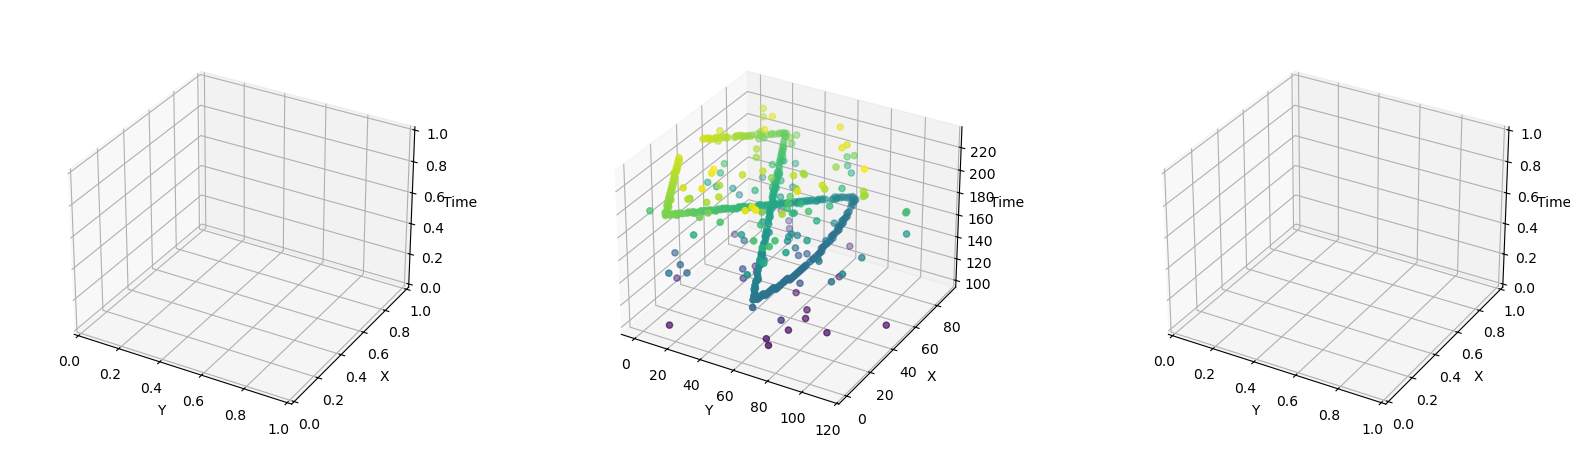

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(a, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(b, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(c, ax3)

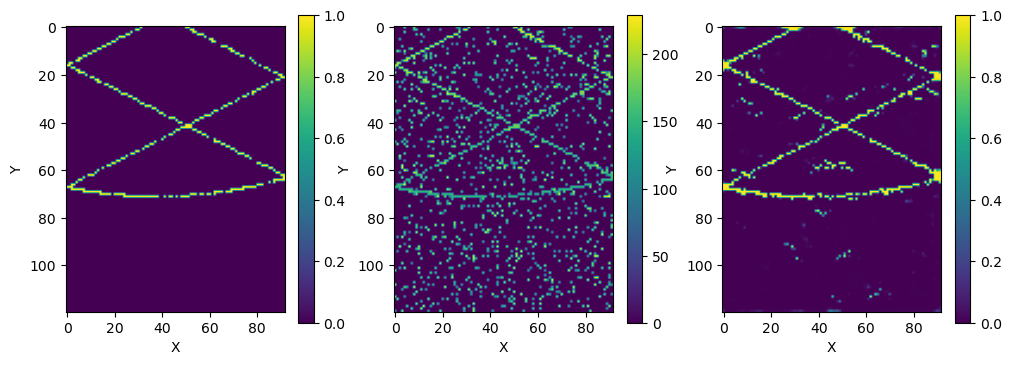

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(test_dataset[0].signal)
ax2 = fig.add_subplot(132)
plot2d(test_dataset[0].sn_time)
ax3 = fig.add_subplot(133)
plot2d(pred[1])

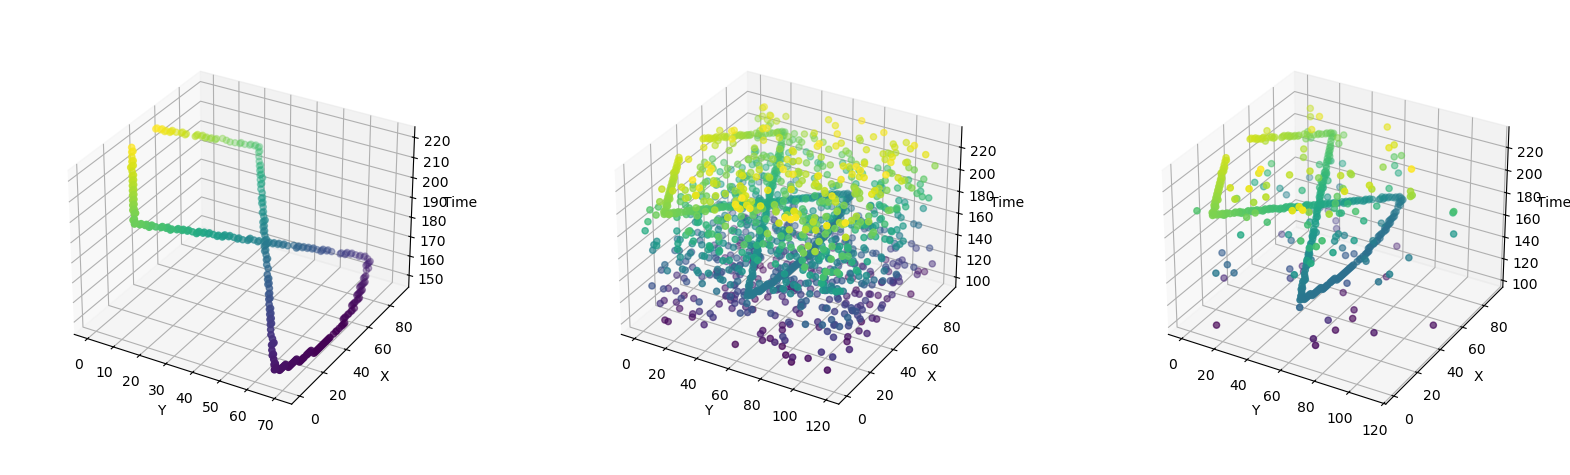

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(test_dataset[0].signal_time, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(test_dataset[0].sn_time, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(b, ax3)